In [1]:
import numpy as np

In [2]:
from TicTacToeEnv import TicTacToeEnvironment

In [3]:
env = TicTacToeEnvironment()
env.print_board()

  |   |  
---------
  |   |  
---------
  |   |  


In [4]:
def encoding_to_idx(encoding):
    values = np.zeros(9)
    for i in range(9):
        values[i] = encoding[i]
    return int(np.sum(values* 3**np.arange(9)))

In [5]:
def epsilon_greedy(epsilon, player_table, string_state):
    valid_indices = []
    for i in range(9):
        if string_state[i] == '0':
            valid_indices.append(i)
    if len(valid_indices) < 1:
        raise ValueError('No valid board choices!?')
    random_action = np.random.choice([True,False], p=[epsilon, (1-epsilon)])
    if random_action:
        return np.random.choice(valid_indices)
    
    valid_choices = player_table[encoding_to_idx(string_state)][valid_indices]
    max_valid = valid_indices[np.argmax(valid_choices)]
    return max_valid

In [18]:
def train(X_player, O_player, env, num_episodes, lr, epsilon_decay, gamma, start_decay, tie_reward=0):
    x_wins_arr = []
    o_wins_arr = []
    ties_arr = []
    x_wins = 0
    o_wins = 0
    ties = 0
    players = [X_player, O_player]
    epsilon = 1
    for episode in range(num_episodes):
        x_up_next_state = env.reset()
        terminated = False
        turn_num = 0
        while (True):
            
            ##X action            
            x_action = epsilon_greedy(epsilon, X_player, x_up_next_state)
            x_just_played_state, x_reward, x_terminated, board_full = env.step(x_action, 'X')
            
            
            ##bellman O update -> can't update on turn 0 yet, O hasn't played
            if turn_num > 0:
                #reward O tie points
                if o_reward == 0 and x_reward == 0 and board_full == True:
                    o_reward = tie_reward
                
                O_player[env.encoding_to_idx(x_play_last_turn), o_action] += \
                lr * ((o_reward + gamma*np.max(O_player[env.encoding_to_idx(x_just_played_state)]) \
                       - O_player[env.encoding_to_idx(x_play_last_turn), o_action]))
                
                if o_terminated or board_full:
                    o_wins+= 1 if o_reward == 1 else 0
                    if board_full and not o_reward:
                        ties+=1
                    break
            x_play_last_turn = x_just_played_state
            
            ##O action
            o_action = epsilon_greedy(epsilon, O_player, x_just_played_state)
            o_just_played_state, o_reward, o_terminated, board_full = env.step(o_action, 'O')
            

            ##bellman X update
            X_player[env.encoding_to_idx(x_up_next_state), x_action] += \
            lr * ((x_reward + gamma*np.max(X_player[env.encoding_to_idx(o_just_played_state)]) \
                   - X_player[env.encoding_to_idx(x_up_next_state), x_action]))
            
            if x_terminated or board_full:
                x_wins+= 1 if x_reward == 1 else 0
                break
        
            x_up_next_state = o_just_played_state
            turn_num += 1
        if episode > start_decay:
            epsilon = np.exp(-epsilon_decay * (episode - start_decay))
        if ((episode + 1) % 10000) == 0:
            print('Episode', episode + 1, 'done')
            print(f'epsilon: {epsilon:.3f}')
            print('X Wins:', x_wins)
            print('O Wins:', o_wins)
            print('Ties:', ties)
            print()
            x_wins_arr.append(x_wins)
            o_wins_arr.append(o_wins)
            ties_arr.append(ties)
    return x_wins_arr, o_wins_arr, ties_arr

In [7]:
##policies ###Yes, 3**9 is way too many states for tictactoe
##however, I chose to encode the states as binary strings for
##simplicity, rather than think about a more efficient way
X_player = np.zeros((3**9, 9))
O_player = np.zeros((3**9, 9))

##environment
env = TicTacToeEnvironment(points_for_tie=False)

##hyperparams
num_episodes = 1000000
lr = 0.2
gamma = 1
start_decay = 300000
epsilon_decay = 5 / (num_episodes - start_decay)

In [8]:
x_wins_arr, o_wins_arr, ties_arr = train(X_player, O_player, env, num_episodes, lr, epsilon_decay, gamma, start_decay)

Episode 10000 done
epsilon: 1.000
X Wins: 3560
O Wins: 2920
Ties: 3520

Episode 20000 done
epsilon: 1.000
X Wins: 7053
O Wins: 5816
Ties: 7131

Episode 30000 done
epsilon: 1.000
X Wins: 10701
O Wins: 8684
Ties: 10615

Episode 40000 done
epsilon: 1.000
X Wins: 14245
O Wins: 11628
Ties: 14127

Episode 50000 done
epsilon: 1.000
X Wins: 17820
O Wins: 14474
Ties: 17706

Episode 60000 done
epsilon: 1.000
X Wins: 21406
O Wins: 17382
Ties: 21212

Episode 70000 done
epsilon: 1.000
X Wins: 25043
O Wins: 20240
Ties: 24717

Episode 80000 done
epsilon: 1.000
X Wins: 28698
O Wins: 23144
Ties: 28158

Episode 90000 done
epsilon: 1.000
X Wins: 32256
O Wins: 26015
Ties: 31729

Episode 100000 done
epsilon: 1.000
X Wins: 35847
O Wins: 28950
Ties: 35203

Episode 110000 done
epsilon: 1.000
X Wins: 39400
O Wins: 31821
Ties: 38779

Episode 120000 done
epsilon: 1.000
X Wins: 42967
O Wins: 34728
Ties: 42305

Episode 130000 done
epsilon: 1.000
X Wins: 46601
O Wins: 37531
Ties: 45868

Episode 140000 done
epsilon:

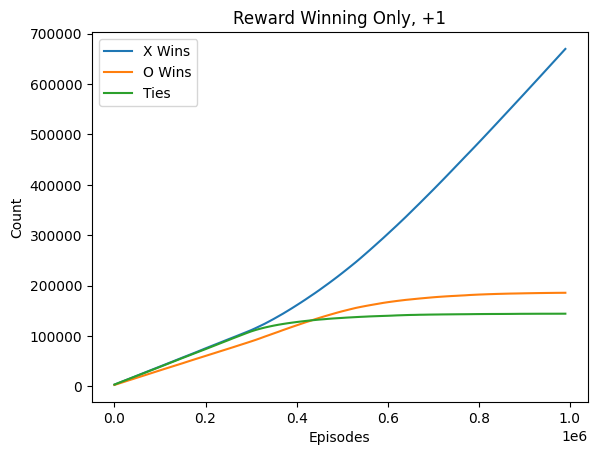

In [37]:
import matplotlib.pyplot as plt
x = np.arange(100) * 10000
plt.plot(x, x_wins_arr, label='X Wins')
plt.plot(x, o_wins_arr, label='O Wins')
plt.plot(x, ties_arr, label='Ties')

plt.xlabel('Episodes')
plt.ylabel('Count')

plt.legend()
plt.title('Reward Winning Only, +1')
plt.show()

In [19]:
##policies
X_player_pt2 = np.zeros((3**9, 9))
O_player_pt2 = np.zeros((3**9, 9))

##environment -> this time allow for O to get 0.5 points for a tie
env = TicTacToeEnvironment(points_for_tie=True, tie_points=1)

##hyperparams
num_episodes = 1000000
lr = 0.2
gamma = 1
start_decay = 300000
epsilon_decay = 5 / (num_episodes - start_decay)

In [20]:
x_wins_arr_pt2, o_wins_arr_pt2, ties_arr_pt2 = \
train(X_player_pt2, O_player_pt2, env, num_episodes, lr, epsilon_decay, gamma, start_decay, tie_reward=0.5)

Episode 10000 done
epsilon: 1.000
X Wins: 3595
O Wins: 2888
Ties: 2271

Episode 20000 done
epsilon: 1.000
X Wins: 7208
O Wins: 5717
Ties: 4542

Episode 30000 done
epsilon: 1.000
X Wins: 10842
O Wins: 8603
Ties: 6766

Episode 40000 done
epsilon: 1.000
X Wins: 14442
O Wins: 11449
Ties: 9065

Episode 50000 done
epsilon: 1.000
X Wins: 18047
O Wins: 14338
Ties: 11298

Episode 60000 done
epsilon: 1.000
X Wins: 21639
O Wins: 17208
Ties: 13616

Episode 70000 done
epsilon: 1.000
X Wins: 25211
O Wins: 20074
Ties: 15941

Episode 80000 done
epsilon: 1.000
X Wins: 28787
O Wins: 23023
Ties: 18168

Episode 90000 done
epsilon: 1.000
X Wins: 32379
O Wins: 25895
Ties: 20408

Episode 100000 done
epsilon: 1.000
X Wins: 36086
O Wins: 28764
Ties: 22594

Episode 110000 done
epsilon: 1.000
X Wins: 39620
O Wins: 31642
Ties: 24914

Episode 120000 done
epsilon: 1.000
X Wins: 43249
O Wins: 34488
Ties: 27162

Episode 130000 done
epsilon: 1.000
X Wins: 46761
O Wins: 37365
Ties: 29480

Episode 140000 done
epsilon: 1

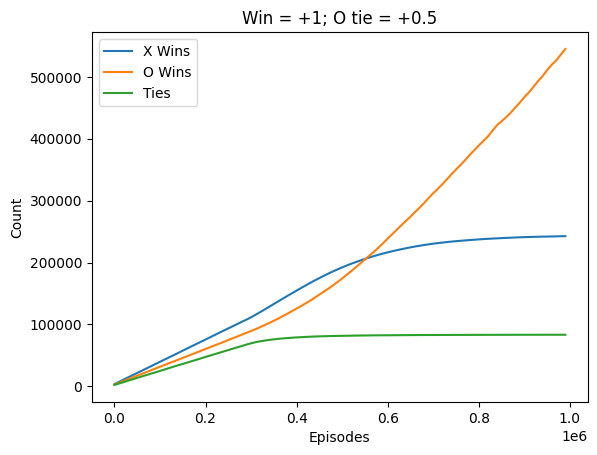

In [36]:
x = np.arange(100) * 10000
plt.plot(x, x_wins_arr_pt2, label='X Wins')
plt.plot(x, o_wins_arr_pt2, label='O Wins')
plt.plot(x, ties_arr_pt2, label='Ties')

plt.xlabel('Episodes')
plt.ylabel('Count')

plt.legend()
plt.title('Win = +1; O tie = +0.5')
plt.show()

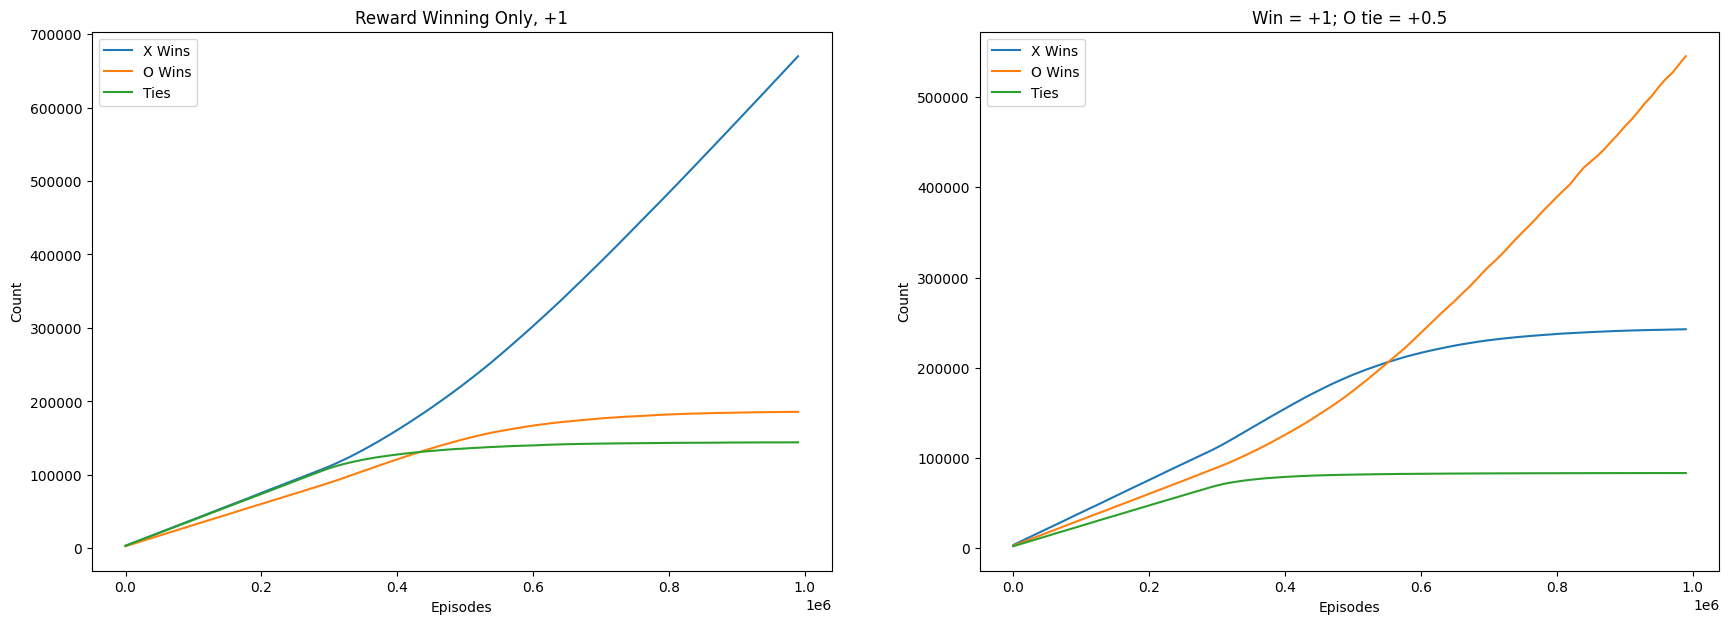

In [63]:
fig = plt.figure(figsize=(21,7))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(x, x_wins_arr, label='X Wins')
ax1.plot(x, o_wins_arr, label='O Wins')
ax1.plot(x, ties_arr, label='Ties')

ax1.legend()
ax1.set_title('Reward Winning Only, +1')

plt.xlabel('Episodes')
plt.ylabel('Count')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(x, x_wins_arr_pt2, label='X Wins')
ax2.plot(x, o_wins_arr_pt2, label='O Wins')
ax2.plot(x, ties_arr_pt2, label='Ties')

ax2.legend()
ax2.set_title('Win = +1; O tie = +0.5')


plt.xlabel('Episodes')
plt.ylabel('Count')

plt.show()

In [22]:
test_env = TicTacToeEnvironment()
state = test_env.reset()

In [23]:
# ##policies
# X_player = np.zeros((3**9, 9))
# O_player = np.zeros((3**9, 9))

In [24]:
test_env.reset()
test_env.play_against_policy(O_player, mode='X', deterministic=True)

  |   |  
---------
  |   |  
---------
  |   |  
choose your move
2
  |   | X
---------
  |   |  
---------
  |   |  
press enter for ai move

  |   | X
---------
  | O |  
---------
  |   |  
choose your move
0
X |   | X
---------
  | O |  
---------
  |   |  
press enter for ai move

X | O | X
---------
  | O |  
---------
  |   |  
choose your move
8
X | O | X
---------
  | O |  
---------
  |   | X
press enter for ai move

X | O | X
---------
  | O |  
---------
  | O | X


In [ ]:
test_env.reset()
test_env.play_against_policy(X_player, mode='O', deterministic=True)

In [25]:
np.max(O_player)

0.9999999999999998

In [26]:
np.min(O_player)

0.0

In [34]:
with open('TrainedPolicies/X_policy.npy', 'wb') as F:
    np.save(F, X_player)
with open('TrainedPolicies/O_policy.npy', 'wb') as F:
    np.save(F,O_player)

In [35]:
with open('TrainedPolicies/X_policy_tieRewarded.npy', 'wb') as F:
    np.save(F,X_player_pt2)
with open('TrainedPolicies/O_policy_tieRewarded.npy', 'wb') as F:
    np.save(F,O_player_pt2)